In [1]:
# imports
import stream_analysis as sa
from gcs import path_handler as ph 
import h5py
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import stream_analysis as sa

In [2]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [3]:
# data parameters
internal_dynamics   =   "isotropic-plummer"
montecarlokey       =   "monte-carlo-014"
NP                  =   int(1e5)
MWpotential         =   "pouliasis2017pii-GCNBody"
GCname              =   "Pal5"

In [4]:
# hyper params  
threshold=50
NKEEPS = 8
outdir="../paper/"
outname="force_on_orbit-{:s}.png".format(montecarlokey)

In [5]:
fileFOOB = ph.ForceOnOrbit(GCname,MWpotential,montecarlokey)
fileTau  = ph.tauDensityMaps(GCname=GCname,MWpotential=MWpotential,montecarlokey=montecarlokey,NP=NP,internal_dynamics=internal_dynamics)

In [6]:
time_foob,tau_foob,mag_total,Perturbers,GCmags = sa.identify_suspects.extract_FOOB(fileFOOB)
tau_centers,time_stamps,tau_counts = sa.identify_suspects.extract_tau_stream_density(fileTau)

In [7]:
# get the envlopes
leftindexes,rightindexes=sa.streamLength.get_envelop_indexes(tau_counts,threshold)
tau_left,tau_right=sa.streamLength.tau_envelopes(tau_centers,leftindexes,rightindexes)

In [8]:
mask=sa.identify_suspects.build_mask_on_FOOB_from_density((time_stamps,tau_left,tau_right),(time_foob,tau_foob,mag_total))
masked_data = mag_total[mask]

In [9]:
# create a kernel for getting more of a momentum measure than force
from scipy import ndimage
kernel = np.ones(4) / 4  # 5-point moving average
convolved_data = ndimage.convolve1d(mag_total, kernel, axis=0, mode='reflect')
convolved_mask = np.ma.masked_where(~mask,convolved_data)
coordinates = sa.identify_suspects.get_peaks(convolved_mask)
coordinates = coordinates[0:NKEEPS]

In [22]:
time,tau,mag,convolved,suspects=sa.identify_suspects.build_output_data(coordinates,tau_foob,time_foob,mag_total,convolved_data,GCmags,Perturbers,NKEEPS)

In [23]:
# outfile=ph.PerturberSuspects(GCname,MWpotential,montecarlokey)
# dframe=pd.read_csv(outfile)
# time = dframe['time'].values
# tau = dframe['tau'].values
# mag=dframe['mag'].values
# suspects=dframe['suspects'].values

In [24]:
def getfigure():
    fig=plt.figure(figsize=(10,8))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1/100],hspace=0.05,wspace=0.1)
    axis1=fig.add_subplot(gs[0,0])
    axis2=fig.add_subplot(gs[1,0])
    caxisFOOB=fig.add_subplot(gs[0,1])
    caxisTau=fig.add_subplot(gs[1,1])
    return fig,axis1,axis2,caxisFOOB,caxisTau

In [25]:
foobNORM,tauNORM,AXIS1,AXIS2,TEXT = sa.identify_suspects.properties(time_foob,tau_left,tau_right,NP,montecarlokey)
AXIS1['xticks']=[]
AXIS1['title']=""
TEXT['ha'] = "right"
TEXT['va'] = "center"
TEXT['rotation'] = 0
TEXT['fontweight'] = "bold"

In [26]:
foobNORM['cmap']  = "afmhot_r"
foobNORM['norm']   = mpl.colors.Normalize(vmin=0,vmax=50)
foobNORM['norm']   = mpl.colors.LogNorm(vmin=1,vmax=100)

In [27]:
suspects

['NGC7089',
 'NGC2808',
 'NGC5272',
 'NGC5904',
 'NGC6981',
 'BH140',
 'NGC6584',
 'NGC7099']

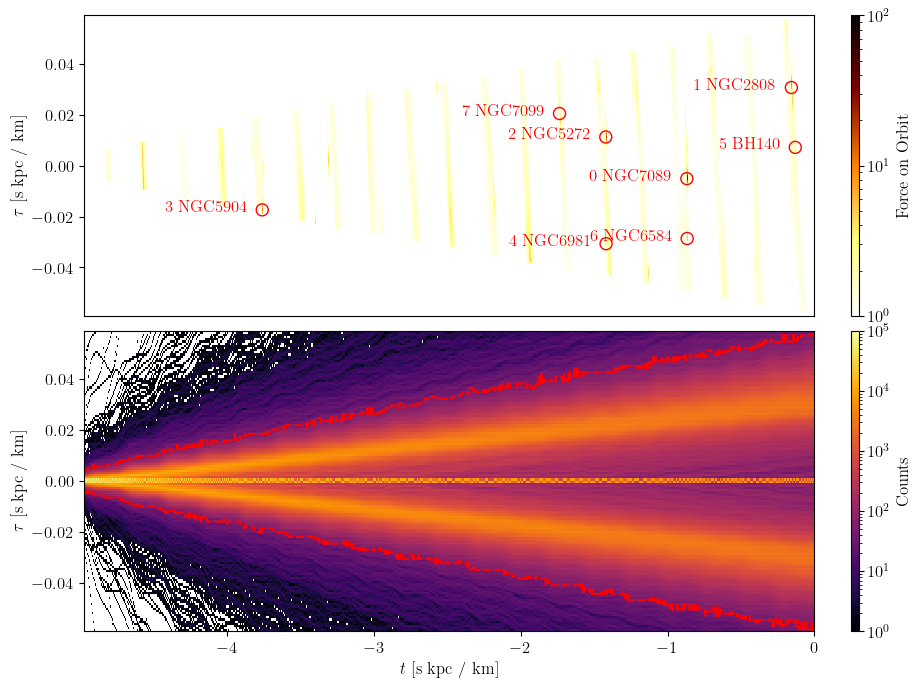

In [28]:
fig,axis1,axis2,caxisFOOB,caxisTau = getfigure()
FIGSTUFF=[fig,axis1,axis2,caxisFOOB,caxisTau]
DATASTUFF=time_foob,tau_foob,convolved_mask,suspects,coordinates,tau_counts,tau_centers,time_stamps,tau_left,tau_right
PROPERTIESSTUFF=foobNORM,tauNORM,AXIS1,AXIS2,TEXT
sa.identify_suspects.doplot(FIGSTUFF,DATASTUFF,PROPERTIESSTUFF,x_text_shift=-0.1,y_text_shift=0.001)
fig.savefig(outdir+outname,dpi=300)